In [1]:
import os
import pickle
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost as xgb
from nilearn import plotting
from nilearn.image import load_img
from torch.utils.data import Dataset, DataLoader, random_split
from monai.networks.nets import DenseNet121
from nilearn import image, datasets, input_data
from nilearn.image import load_img, resample_img, resample_to_img
from nilearn.datasets import load_mni152_template
from tqdm.notebook import tqdm

C:\Users\eugen\anaconda3\envs\tensorflow\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# 1. Data

In [2]:
def collect_data(data_dir):
    """
    Traverse the data directory and return three lists:
      - anatomical image file paths
      - resting state fMRI file paths
      - labels (1 for ASD, 0 for TC)
    """
    anat_files = []
    fmri_files = []
    labels = []
    
    # subdirectories for each institution
    files = ['ABIDEII-EMC_1', 'ABIDEII-GU_1', 'ABIDEII-KKI_1',
             'ABIDEII-U_MIA_1', 'ABIDEII-NYU_2', 'ABIDEII-SU_2']
    i = 0
    
    for dataset in os.listdir(data_dir):
        # Paths for ASD and TC for both anatomical and fMRI data
        asd_path_anat = os.path.join(data_dir, dataset, files[i], "ASD")
        tc_path_anat = os.path.join(data_dir, dataset, files[i], "TC")
        asd_path_fmri = os.path.join(data_dir, dataset, files[i], "ASD")
        tc_path_fmri = os.path.join(data_dir, dataset, files[i], "TC")
        
        # Process ASD subjects
        if os.path.exists(asd_path_anat):
            for subject in os.listdir(asd_path_anat):
                anat_path = os.path.join(asd_path_anat, subject, "session_1", "anat_1")
                fmri_path = os.path.join(asd_path_fmri, subject, "session_1", "rest_1")
                if os.path.exists(anat_path) and os.path.exists(fmri_path):
                    anat_file = os.path.join(anat_path, os.listdir(anat_path)[0])
                    fmri_file = os.path.join(fmri_path, os.listdir(fmri_path)[0])
                    anat_files.append(anat_file)
                    fmri_files.append(fmri_file)
                    labels.append(1)
                    
        # Process TC subjects
        if dataset != 'NYU Langone':
            if os.path.exists(tc_path_anat):
                for subject in os.listdir(tc_path_anat):
                    anat_path = os.path.join(tc_path_anat, subject, "session_1", "anat_1")
                    fmri_path = os.path.join(tc_path_fmri, subject, "session_1", "rest_1")
                    if os.path.exists(anat_path) and os.path.exists(fmri_path):
                        anat_file = os.path.join(anat_path, os.listdir(anat_path)[0])
                        fmri_file = os.path.join(fmri_path, os.listdir(fmri_path)[0])
                        anat_files.append(anat_file)
                        fmri_files.append(fmri_file)
                        labels.append(0)
                        
        i += 1
        
    return anat_files, fmri_files, labels

# 2. Data Visualization

In [3]:
def visualize_anatomical_sample(anat_files, sample_index=0):
    """
    Visualizes a sample anatomical brain scan using nilearn's plotting functions.
    """
    
    print(f"Visualizing sample at index: {sample_index}")
    
    # Load the NIfTI file.
    file_path = anat_files[sample_index]
    img = load_img(file_path)
    
    # Display an interactive viewer (this opens in a browser or in a Jupyter widget).
    view = plotting.view_img(img, threshold=None, title="Interactive Brain Scan")
    # In Jupyter notebooks, simply returning the view object will display it.
    display(view)
    
    # Display static plots with different orientations.
    plotting.plot_anat(img, display_mode='ortho', title="Orthogonal Slices")
    plotting.plot_anat(img, display_mode='x', cut_coords=10, title="Sagittal Slices")
    plotting.plot_anat(img, display_mode='y', cut_coords=10, title="Coronal Slices")
    plotting.plot_anat(img, display_mode='z', cut_coords=10, title="Axial Slices")
    
    # Render the plots.
    plotting.show()

# 3. Custom Pytorch Dataset

In [4]:
class AutismDataset(Dataset):
    def __init__(self, anat_files, fmri_files, labels, target_shape, cache_file=None):
        """
        Loads anatomical images (resampled and normalized) on and precomputes
        fMRI ROI features using a masker.
        """
        self.anat_files = anat_files
        self.fmri_files = fmri_files
        self.labels = labels
        self.target_shape = target_shape
        
        # MNI template for anatomical resampling
        self.mni_template = load_mni152_template()
        
        # FMRI masker using the Harvard–Oxford Cortical Atlas
        atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
        self.masker_fmri = input_data.NiftiLabelsMasker(
            labels_img=atlas.maps,
            standardize=True,
            detrend=True,
            low_pass=0.1,
            high_pass=0.01,
            t_r=2.0,
            resampling_target="data"
        )
        
        # Load cached features if available
        if cache_file is not None and os.path.exists(cache_file):
            print(f"Loading cached fMRI features from {cache_file}...")
            with open(cache_file, 'rb') as f:
                self.fmri_features = pickle.load(f)
        else:
            print("Precomputing fMRI features...")
            self.fmri_features = []
            for fmri_path in tqdm(self.fmri_files, desc="Processing fMRI data"):
                fmri_img = load_img(fmri_path)
                time_series = self.masker_fmri.fit_transform(fmri_img)
                mean_ts = np.mean(time_series, axis=0) # Compute the mean time series for each region.
                self.fmri_features.append(mean_ts.astype(np.float32))
            if cache_file is not None:
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.fmri_features, f)
                print(f"Cached fMRI features saved to {cache_file}")

    def __len__(self):
        return len(self.anat_files)

    def __getitem__(self, idx):
        # --- Anatomical Data Processing ---
        anat_path = self.anat_files[idx]
        anat_img = load_img(anat_path)
        # Resample to MNI space using the template (this keeps spatial alignment)
        anat_resampled = resample_to_img(anat_img, self.mni_template)
        anat_data = anat_resampled.get_fdata().astype(np.float32)

        # Convert the numpy array to a torch tensor with shape (1, D, H, W)
        anat_tensor = torch.tensor(anat_data).unsqueeze(0)

        # Use torch.nn.functional.interpolate to resize to the desired target shape.
        # First, add a batch dimension so the shape becomes (1, 1, D, H, W).
        anat_tensor = F.interpolate(anat_tensor.unsqueeze(0), size=self.target_shape, mode='trilinear', align_corners=False)
        # Remove the extra batch dimension so that shape becomes (1, target_D, target_H, target_W)
        anat_tensor = anat_tensor.squeeze(0)

        # Z-score normalization
        anat_tensor = (anat_tensor - anat_tensor.mean()) / (anat_tensor.std() + 1e-5)

        # --- fMRI Features Processing ---
        expected_dim = 48
        fmri_feat = self.fmri_features[idx]
        if fmri_feat.shape[0] < expected_dim:
            fmri_feat = np.pad(fmri_feat, (0, expected_dim - fmri_feat.shape[0]), mode='constant')
        elif fmri_feat.shape[0] > expected_dim:
            fmri_feat = fmri_feat[:expected_dim]
        fmri_tensor = torch.tensor(fmri_feat)

        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return anat_tensor, fmri_tensor, label_tensor

# 4. Multi-modal Model

In [5]:
# XGBoost fMRI Branch Module
class XGBFMRIBranch(nn.Module):
    def __init__(self, model_path="models/xgb_fmri.model"):
        """
        Loads a pre-trained XGBoost model from disk.
        This branch is not trainable (non-differentiable) and is used as-is.
        """
        super(XGBFMRIBranch, self).__init__()
        self.xgb_model = xgb.Booster()
        self.xgb_model.load_model(model_path)
    
    def forward(self, x):
        x_np = x.detach().cpu().numpy()
        dmatrix = xgb.DMatrix(x_np)
        # Get predictions
        preds = self.xgb_model.predict(dmatrix)
        # Convert predictions back to a tensor and reshape to (B, 1)
        preds_tensor = torch.tensor(preds, dtype=torch.float32, device=x.device).unsqueeze(1)
        return preds_tensor

# Multi-modal Model with DenseNet121 (Anatomical) and XGBoost (fMRI)
class MultiModalDenseNet(nn.Module):
    def __init__(self, anat_feature_size=128, num_classes=2, xgb_model_path="models/xgb_fmri.model"):
        """
        anat_feature_size: Dimension of the feature vector output by the anatomical branch.
        xgb_model_path: Path to pre-trained XGBoost model.
        """
        super(MultiModalDenseNet, self).__init__()

        self.anat_branch = DenseNet121(spatial_dims=3, in_channels=1, out_channels=anat_feature_size)
        
        # fMRI branch
        self.fmri_branch = XGBFMRIBranch(model_path=xgb_model_path)
        
        # Concatenate along the feature dimension and classify.
        self.fusion_fc = nn.Sequential(
            nn.Linear(anat_feature_size + 1, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, anat, fmri):
        # Process anatomical images with DenseNet121
        anat_features = self.anat_branch(anat)
        # Process fmri features with XGBoost
        fmri_output = self.fmri_branch(fmri)
        # Fuse features
        combined = torch.cat((anat_features, fmri_output), dim=1)
        logits = self.fusion_fc(combined)
        return logits

# 5. Training

In [6]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, accumulation_steps=4):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        print(f"\nStarting Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        
        # progress bar
        train_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                         desc=f"Epoch {epoch+1}/{epochs} Training", leave=False)
        optimizer.zero_grad()
        for batch_idx, (anat, fmri, labels) in train_bar:
            anat = anat.to(device)
            fmri = fmri.to(device)
            labels = labels.to(device)
            
            outputs = model(anat, fmri)
            loss = criterion(outputs, labels)
            # Scale loss
            loss = loss / accumulation_steps
            loss.backward()
            
            running_loss += loss.item() * accumulation_steps
            
            # optimizer step
            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            train_bar.set_postfix(loss=f"{loss.item()*accumulation_steps:.4f}")
        
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for anat, fmri, labels in val_loader:
                anat = anat.to(device)
                fmri = fmri.to(device)
                labels = labels.to(device)
                outputs = model(anat, fmri)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Val Acc: {val_acc:.4f}")
        
        # Save model
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        model_path = os.path.join('model_checkpoints', 'Dense_anat_rest', f'model_epoch_{epoch+1}.pt')
        torch.save(checkpoint, model_path)
        print(f"Saved model_epoch_{epoch+1}.pt")
        
        # update best_val_acc and save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }
            model_path = os.path.join('model_checkpoints', 'Dense_anat_rest', "best_model.pt")
            torch.save(checkpoint, model_path)
            print("Saved best_model.pt")

# 6. Main Function

In [7]:
data_dir = "Data"  # Data path
anat_files, fmri_files, labels = collect_data(data_dir)
print(f"Found {len(anat_files)} subjects.")

Found 468 subjects.


Visualizing sample at index: 0


C:\Users\eugen\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



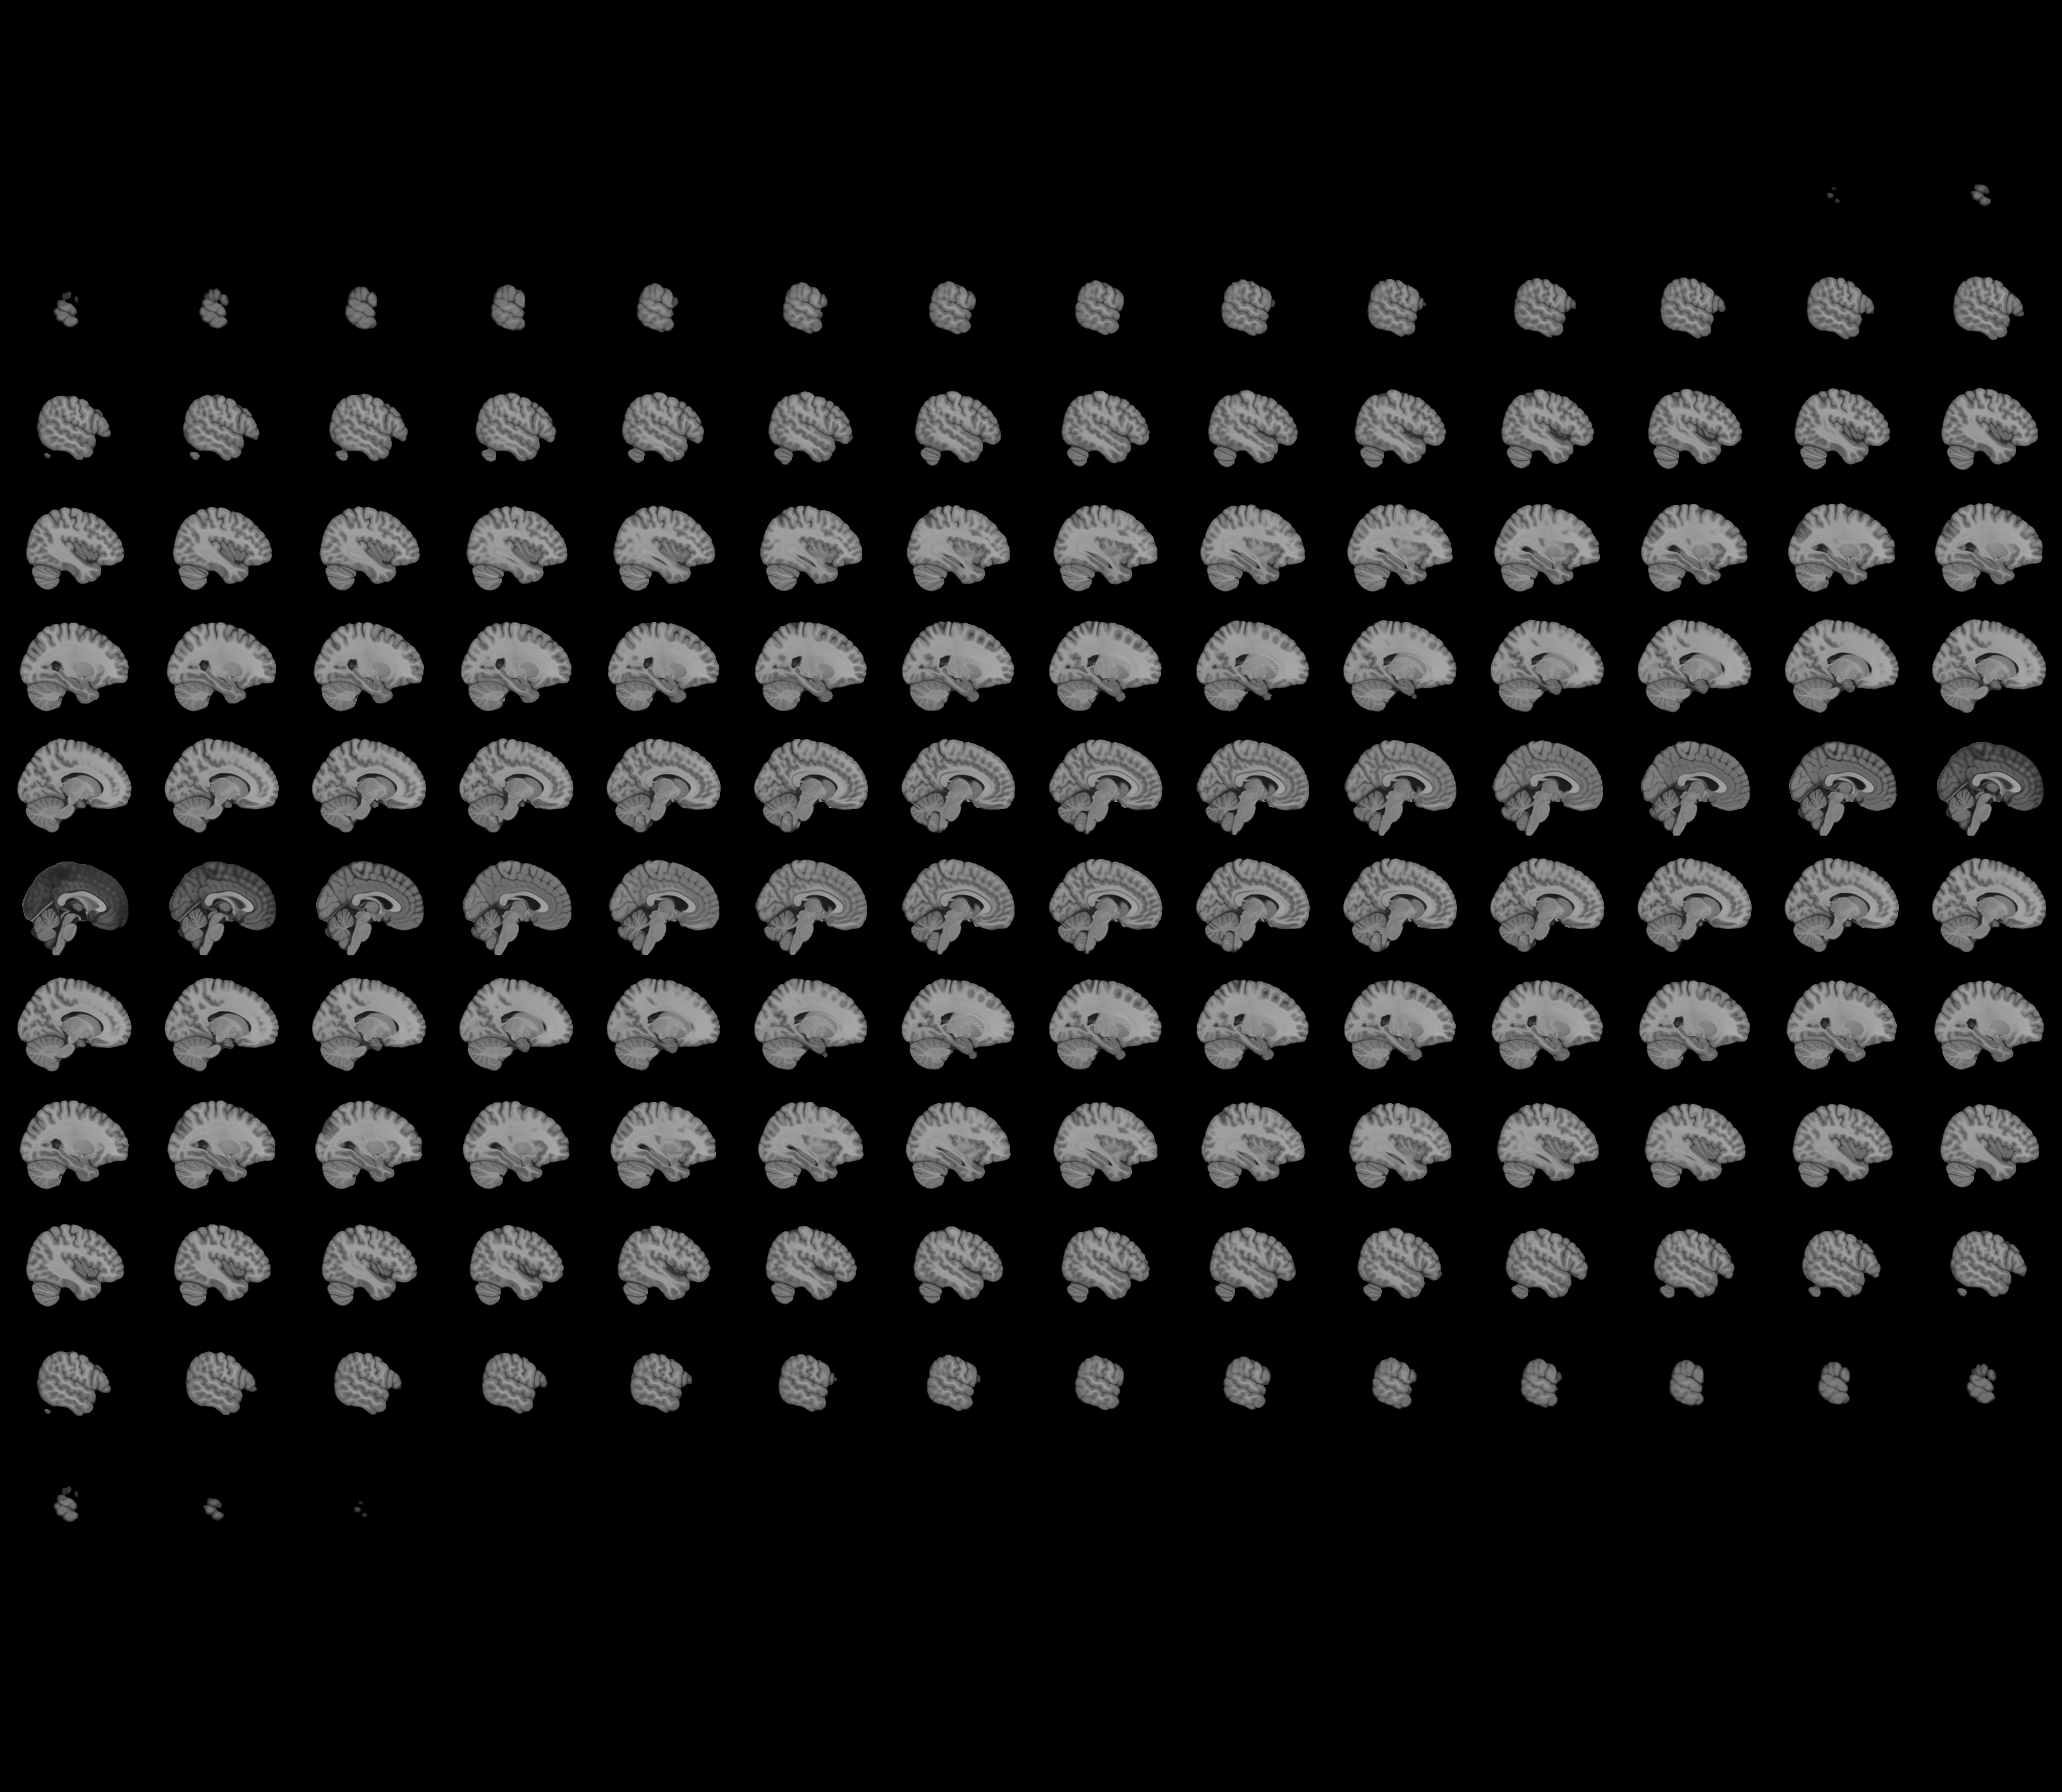
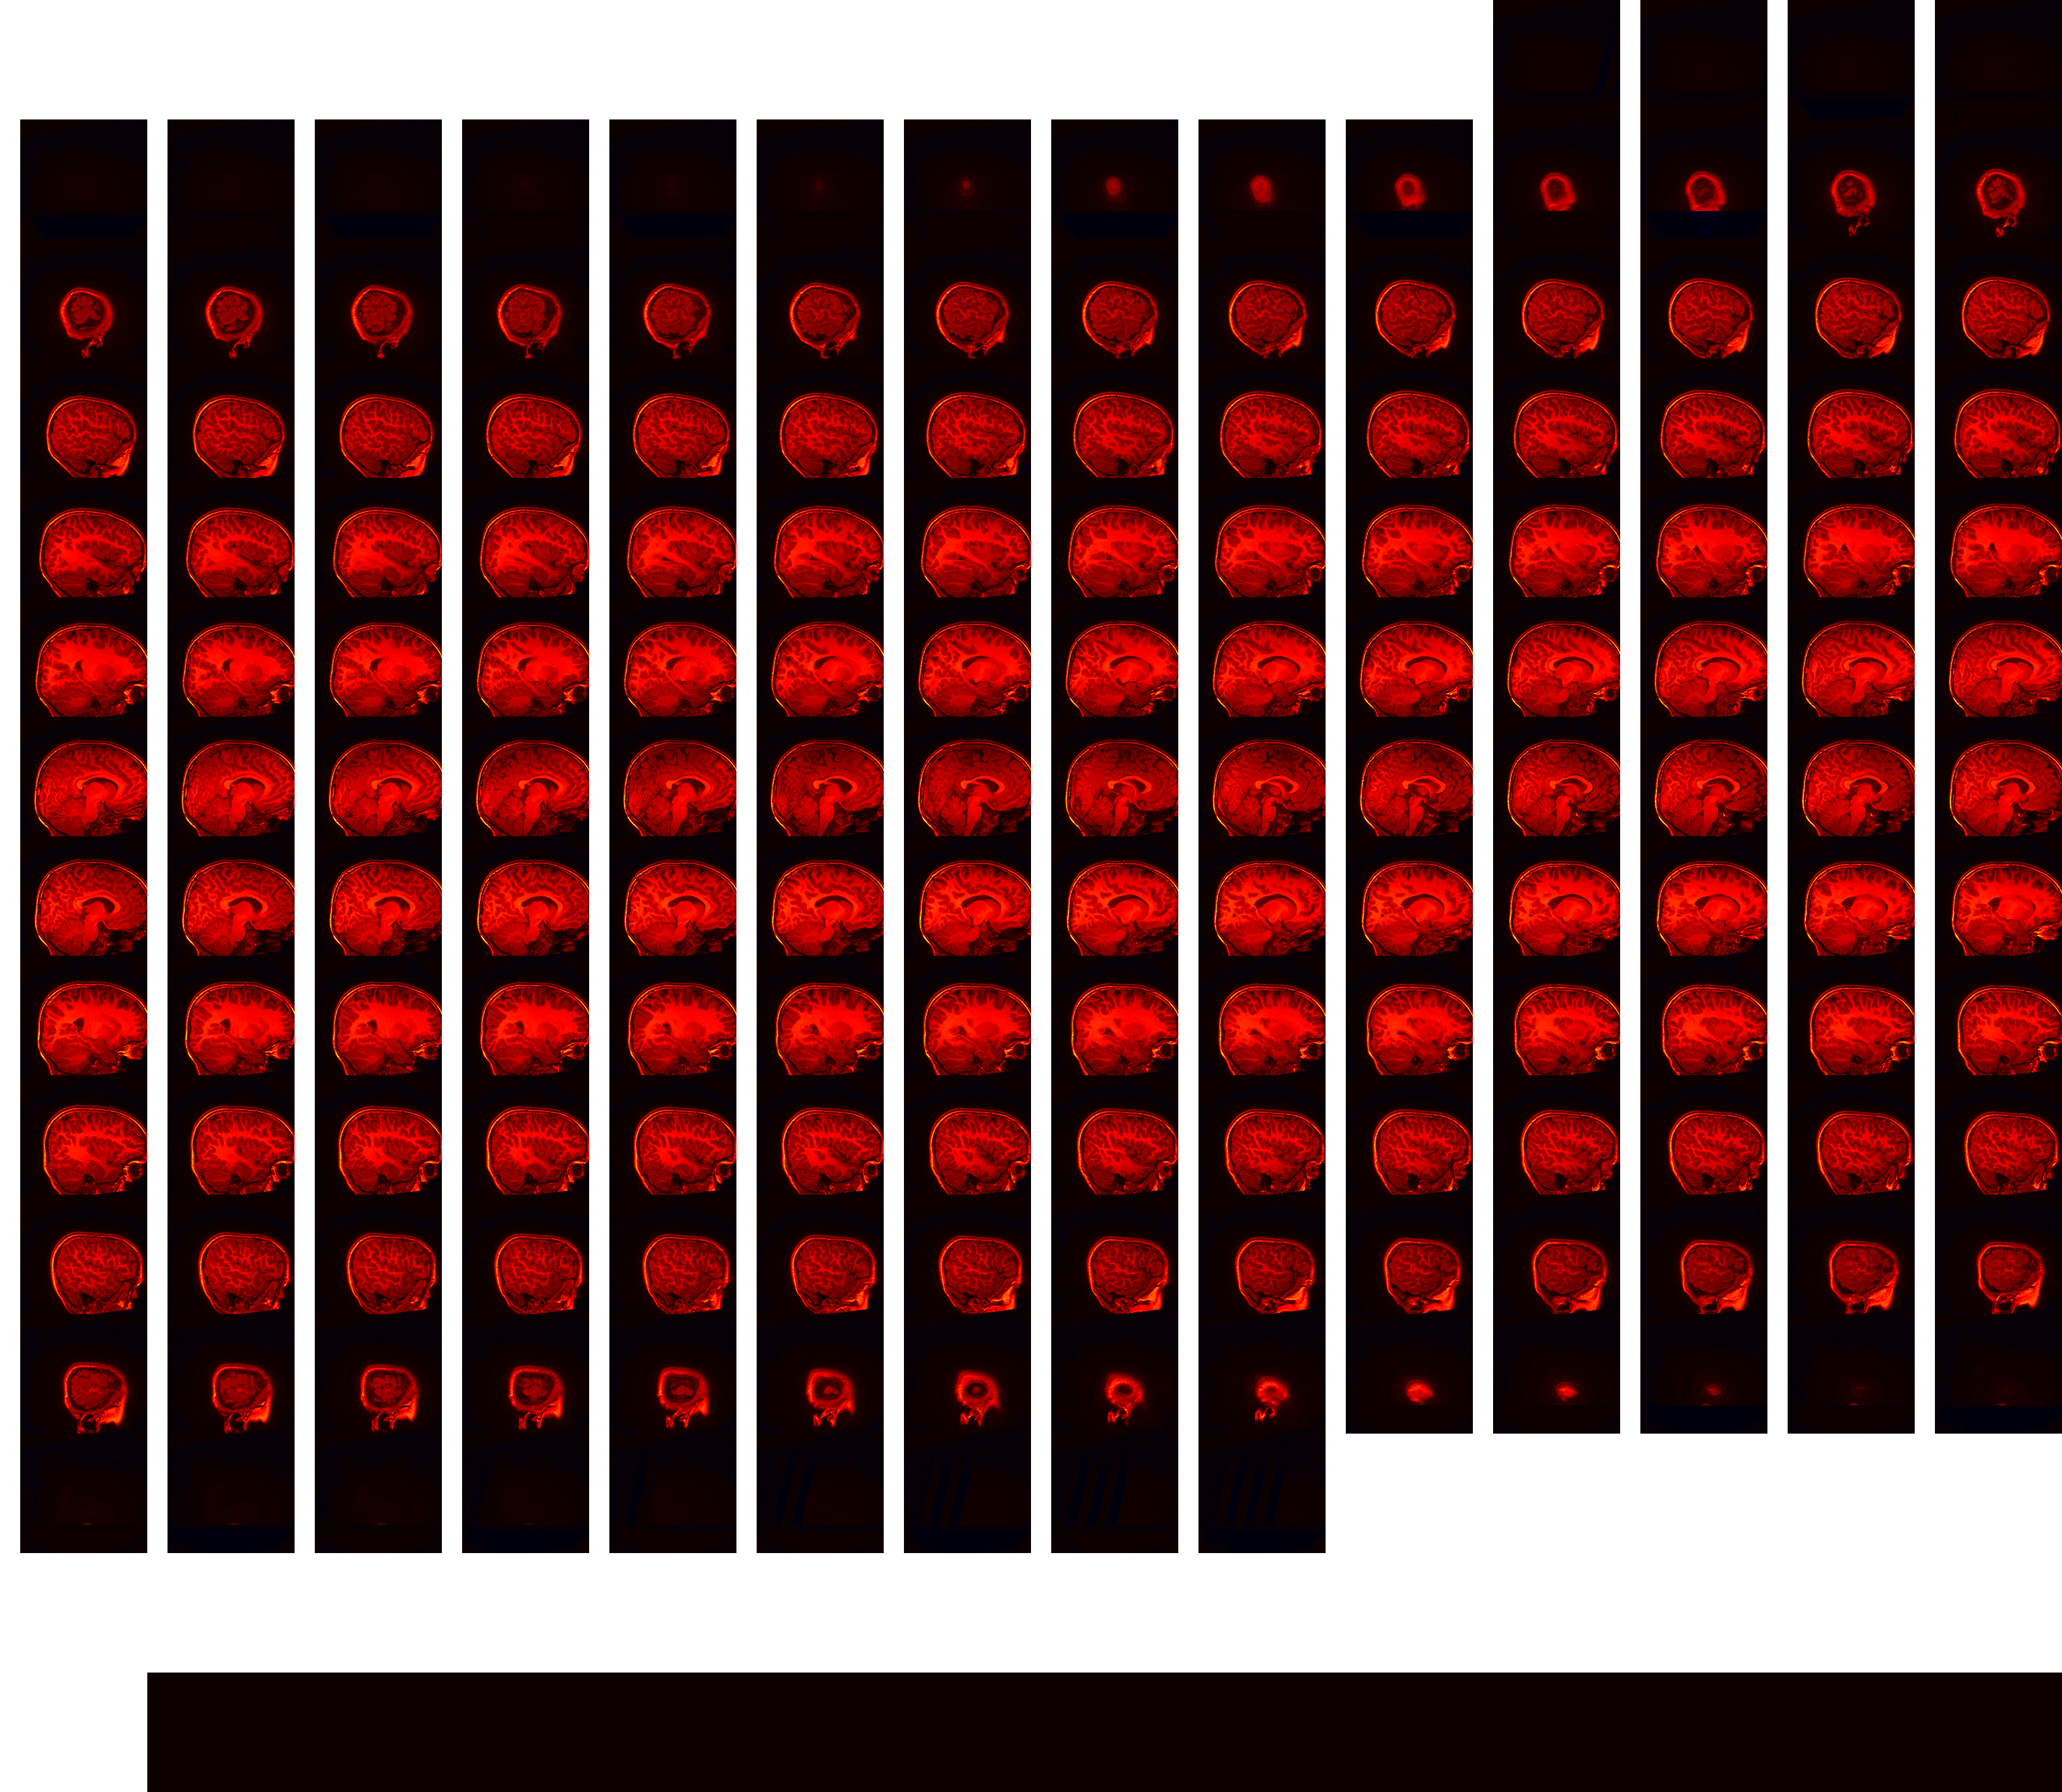

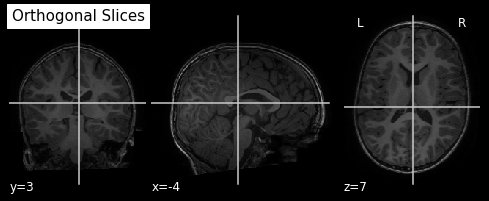

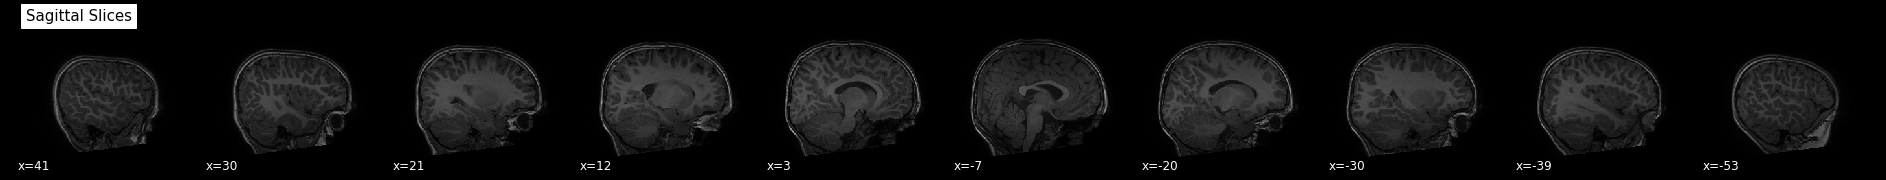

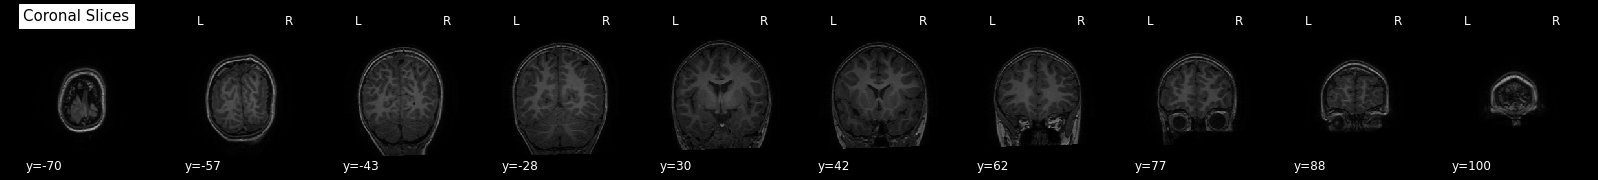

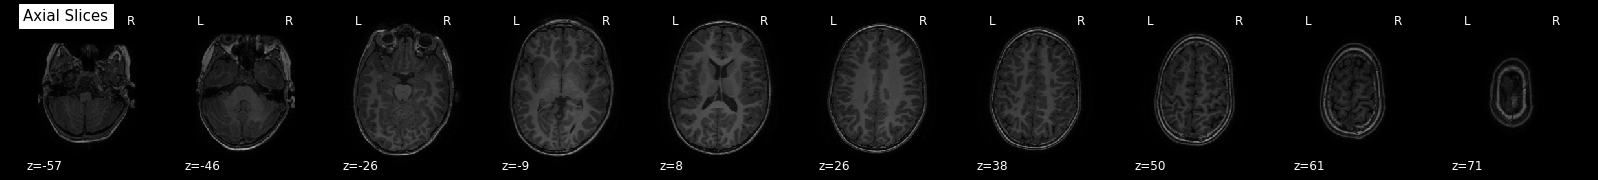

In [8]:
visualize_anatomical_sample(anat_files, sample_index=0)

In [7]:
# cache file for fMRI features if avilable
cache_file = "fmri_features_cache_176_256_256.pkl"

# Create dataset
dataset = AutismDataset(anat_files, fmri_files, labels, target_shape=(176, 256, 256), cache_file=cache_file)

Loading cached fMRI features from fmri_features_cache_176_256_256.pkl...


In [8]:
# Split into training and validation sets (80/20 split)
total_subjects = len(dataset)
train_size = int(0.8 * total_subjects)
val_size = total_subjects - train_size

# Create a generator with a fixed seed.
g = torch.Generator()
g.manual_seed(114)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=g)

In [9]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [10]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
model = MultiModalDenseNet()

In [12]:
#model.to(device)

In [13]:
# Train model
#train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4)

In [14]:
checkpoint_path = "model_checkpoints/Dense121_anat_rest/model_epoch_2.pt"  # or your filename for the best model.
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [15]:
model.to(device)

MultiModalDenseNet(
  (anat_branch): DenseNet121(
    (features): Sequential(
      (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (layers): Sequential(
            (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
      

In [16]:
# Evaluation loop.
all_preds = []
all_labels = []

In [17]:
from sklearn.metrics import accuracy_score

In [ ]:
with torch.no_grad():
    for anat, fmri, labels in val_loader:
        anat = anat.to(device)
        fmri = fmri.to(device)
        labels = labels.to(device)
        
        outputs = model(anat, fmri)
        # Get predicted class (assumes outputs are logits)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all predictions and labels.
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute accuracy.
accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", accuracy)

C:\Users\eugen\anaconda3\envs\tensorflow\lib\site-packages\nilearn\image\resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\Users\eugen\anaconda3\envs\tensorflow\lib\site-packages\nilearn\image\resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\Users\eugen\anaconda3\envs\tensorflow\lib\site-packages\nilearn\image\resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
